# Gradient metasurface reflector

Electromagnetic metamaterials and metasurfaces are artificially engineered structures made of subwavelength resonating unit cells. By utilizing various design principles, they have enabled fascinating electromagnetic phenomena and capabilities such as negative refraction, cloaking, perfect absorption, high-NA focusing, and so on. In Tidy3D's example library, we have demonstrated a [dielectric metasurface absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/DielectricMetasurfaceAbsorber/), a [metalens at the visible frequency](https://www.flexcompute.com/tidy3d/examples/notebooks/Metalens/), and a [graphene metamaterial absorber](https://www.flexcompute.com/tidy3d/examples/notebooks/GrapheneMetamaterial/). 

This notebook demonstrates a near-infrared metasurface reflector consisting of plasmonic antennas. First, we model the unit cell and extract the relationship between a geometric parameter and the corresponding complex reflection coefficient. Then, a super cell consisting of ten antennas is designed to exhibit a linear reflection phase such that the incident light can be diffracted to a particular angle efficiently. By a similar procedure, other beam shaping devices and metalenses can be designed according to different phase profiles. 

This example is based on the landmark work [Sun, S.; Yang, K.-Y.; Wang, C.-M.; Juan, T.-K.; Chen, W.T.; Liao, C.Y.; He, Q.; Xiao, S.; Kung, W.-T.; Guo, G.-Y.; et al. High-Efficiency Broadband Anomalous Reflection by Gradient Meta-Surfaces. Nano Lett. 2012, 12, 6223–6229](https://pubs.acs.org/doi/abs/10.1021/nl3032668).

<img src="img/gradient_metasurface_reflector_schematic.png" width="600" alt="Schematic of the gradient metasurface reflector">

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
import tidy3d.web as web


## Unit Cell Simulation 

### Simulation Setup 

In the first part of the notebook, we simulate a unit cell that consists of a rectangular gold antenna, a dielectric spacer, and a gold film on glass substrate. The thickness of the gold film is $d_3$=130 nm. The thickness of the spacer is $d_2$ = 50 nm. The thickness and width of the antenna are $d_1$=30 nm and $w$=90 nm. The only parameter we can vary is the length of the antenna $L$. The periodicities in x and y directions are $L_x$=120 nm and $L_y$=300 nm, respectively.

First, define the simulation frequency and wavelength ranges.

In [2]:
lda0 = 0.85  # central wavelength
freq0 = td.C_0 / lda0  # central frequency


Define geometric parameters.

In [3]:
Lx = 0.12  # unit cell size in x direction
Ly = 0.3  # unit cell size in y direction
d1 = 0.03  # antenna thickness
d2 = 0.05  # spacer thickness
d3 = 0.13  # gold layer thickness
w = 0.09  # antenna width
inf_eff = 1e2  # effective infinity


Three materials will be defined in this model: gold for the antennas and the back plate, magnesium fluoride for the spacer, and silica for the substrate. Magnesium fluoride and silica will be modeled as lossless and non-dispersive dielectrics while gold will be modeled as a dispersive medium. 

More specifically, magnesium fluoride has a permittivity of 1.892 and silica has a permittivity of 2.25. For gold, we use one option from the Tidy3D's built-in [Material Library](../material_library.html). More specifically, we use the evaporated gold data from [Olmon et al](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.86.235147). There are other options for gold, as well as other common materials, in the [Material Library](../material_library.html).

In [4]:
# define MgF2 material for the spacer layer
mgf2 = td.Medium(permittivity=1.892)

# using material library gold refractive index
au = td.material_library["Au"]["Olmon2012evaporated"]

# define SiO2 material for the substrate
sio2 = td.Medium(permittivity=2.25)


Construct the substrate, gold film, spacer, and antenna structures.  

In [5]:
# define SiO2 substrate
sub = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -inf_eff), rmax=(inf_eff, inf_eff, -d3)
    ),
    medium=sio2,
)

# define gold layer
gold_layer = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, -d3), rmax=(inf_eff, inf_eff, 0)
    ),
    medium=au,
)

# define MgF2 spacer layer
spacer = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-inf_eff, -inf_eff, 0), rmax=(inf_eff, inf_eff, d2)
    ),
    medium=mgf2,
)


Define a linearly polarized [PlaneWave](../_autosummary/tidy3d.PlaneWave.html) as the excitation source. The polarization is chosen to be in the y direction. Also define a [DiffractionMonitor](../_autosummary/tidy3d.DiffractionMonitor.html) on the reflection side to extract the complex reflection coefficient.

In [6]:
fwidth = freq0 / 10  # width of the gaussian pulse

# define a plane wave excitation source
plane_wave = td.PlaneWave(
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    size=(td.inf, td.inf, 0),
    center=(0, 0, 0.3 * lda0),
    direction="-",
    pol_angle=np.pi / 2,  # polarization is set to y direction
)

# define a diffraction monitor to calculate the reflection coefficient
monitor_r = td.DiffractionMonitor(
    center=[0, 0, 0.6 * lda0], size=[td.inf, td.inf, 0], freqs=[freq0], name="R"
)


To perform a parameter sweep over antenna length, it is convenient to define a function that builds the simulation with a given antenna length $L$. Later, this function will be called repeatedly to construct a simulation batch for parameter sweep.

In [7]:
Lz = 1.5 * lda0  # simulation domain size in z direction
sim_size = [Lx, Ly, Lz]

run_time = 3e-13  # simulation run time

boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PML(), plus=td.PML()),
)

# define a function to build simulation given antenna length L
def make_sim(L):
    # define the gold antenna
    antenna = td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-w / 2, -L / 2, d2), rmax=(w / 2, L / 2, d2 + d1)
        ),
        medium=au,
    )
    unit_cell = [sub, gold_layer, spacer, antenna]

    # set up simulation
    sim = td.Simulation(
        size=sim_size,
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
        structures=unit_cell,
        sources=[plane_wave],
        monitors=[monitor_r],
        run_time=run_time,
        boundary_spec=boundary_spec,  # pml is applied to z direction. x and y directions are periodic
    )
    return sim


To ensure the simulation setup is correct, let's test a specific case where the antenna length is 150 nm and visualize the simulation. From the plot, the geometry, source, and monitor all seem to be correctly defined. 

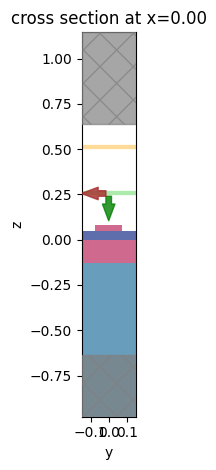

In [8]:
# test a case where the antenna length is 150 nm
sim = make_sim(0.15)
# visualize the simulation
sim.plot(x=0)
plt.show()


To have a better visualization, we can also plot the simulation in 3D.

In [9]:
sim.plot_3d()

Now we are ready to perform the parameter sweep. In this particular case, we investigate antenna length from 40 nm to 280 nm. This is broken down into 14 simulations. A simulation batch is constructed by calling the `make_sim` function with different antenna lengths. 

In [10]:
Ls = np.linspace(0.04, 0.28, 14)  # antenna lengths for parameter sweep

sims = {f"L={L:.2f}": make_sim(L) for L in Ls}  # construct simulation batch


Submit the simulation batch to the server.

In [11]:
# submit simulation batch to the server
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")


[15:25:56] Created task 'L=0.04' with task_id                      ]8;id=327748;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=28608;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1'.                       

           View task using web UI at                               ]8;id=581172;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=200178;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=211098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=710878;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\taskId]8;;\]8;id=211098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\=]8;;\]8;id=618798;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\fdve]8;;\]8;id=211098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\-]8;;\              
           ]8;id=211098;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1\e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1']8;;\.                             

Output()

[15:25:57] Created task 'L=0.06' with task_id                      ]8;id=385258;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=402991;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1'.                       

           View task using web UI at                               ]8;id=853601;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=633907;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=457557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=162068;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\taskId]8;;\]8;id=457557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\=]8;;\]8;id=732540;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\fdve]8;;\]8;id=457557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\-]8;;\              
           ]8;id=457557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1\ea215c6c-27f8-4dae-b193-3c90dbdec55cv1']8;;\.                             

Output()

           Created task 'L=0.08' with task_id                      ]8;id=286873;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=16996;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1'.                       

           View task using web UI at                               ]8;id=915993;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=170292;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=600586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=97060;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\taskId]8;;\]8;id=600586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\=]8;;\]8;id=435257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\fdve]8;;\]8;id=600586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\-]8;;\              
           ]8;id=600586;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1\c65925e3-464b-42bf-8323-3040b5a315b5v1']8;;\.                             

Output()

           Created task 'L=0.10' with task_id                      ]8;id=674925;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=425991;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1'.                       

           View task using web UI at                               ]8;id=321300;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=107724;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=788162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=482382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\taskId]8;;\]8;id=788162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\=]8;;\]8;id=420991;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\fdve]8;;\]8;id=788162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\-]8;;\              
           ]8;id=788162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1\a546a4e8-3069-418b-990f-3dd273f2650bv1']8;;\.                             

Output()

[15:25:58] Created task 'L=0.11' with task_id                      ]8;id=175316;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=526075;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1'.                       

           View task using web UI at                               ]8;id=452202;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=812854;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=153444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=506504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\taskId]8;;\]8;id=153444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\=]8;;\]8;id=376038;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\fdve]8;;\]8;id=153444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\-]8;;\              
           ]8;id=153444;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1\fa7a4d07-6cd1-4789-8751-162ecd3a0434v1']8;;\.                             

Output()

           Created task 'L=0.13' with task_id                      ]8;id=675032;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=620181;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1'.                       

           View task using web UI at                               ]8;id=951808;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=5693;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=961018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=554205;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\taskId]8;;\]8;id=961018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\=]8;;\]8;id=463006;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\fdve]8;;\]8;id=961018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\-]8;;\              
           ]8;id=961018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1\f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1']8;;\.                             

Output()

[15:25:59] Created task 'L=0.15' with task_id                      ]8;id=633318;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=590343;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1'.                       

           View task using web UI at                               ]8;id=366610;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=192767;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=19406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=849855;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\taskId]8;;\]8;id=19406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\=]8;;\]8;id=285949;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\fdve]8;;\]8;id=19406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\-]8;;\              
           ]8;id=19406;https://tidy3d.simulation.cloud/workbench?taskId=fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1\34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1']8;;\.                             

Output()

           Created task 'L=0.17' with task_id                      ]8;id=732071;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=737760;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1'.                       

           View task using web UI at                               ]8;id=377844;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=805699;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=751985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=934560;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\taskId]8;;\]8;id=751985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\=]8;;\]8;id=688156;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\fdve]8;;\]8;id=751985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\-]8;;\              
           ]8;id=751985;https://tidy3d.simulation.cloud/workbench?taskId=fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1\72490fcf-240e-480c-80e4-a27a55ddf850v1']8;;\.                             

Output()

[15:26:00] Created task 'L=0.19' with task_id                      ]8;id=368290;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=380773;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1'.                       

           View task using web UI at                               ]8;id=541060;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=781060;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=184179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=625795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\taskId]8;;\]8;id=184179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\=]8;;\]8;id=804888;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\fdve]8;;\]8;id=184179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\-]8;;\              
           ]8;id=184179;https://tidy3d.simulation.cloud/workbench?taskId=fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1\74c8edad-027a-4e99-8cb6-8a8bca309036v1']8;;\.                             

Output()

           Created task 'L=0.21' with task_id                      ]8;id=433912;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=473089;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1'.                       

           View task using web UI at                               ]8;id=734764;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=377636;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=918129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=224628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\taskId]8;;\]8;id=918129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\=]8;;\]8;id=348945;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\fdve]8;;\]8;id=918129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\-]8;;\              
           ]8;id=918129;https://tidy3d.simulation.cloud/workbench?taskId=fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1\cc069453-3324-4783-824a-b3ba3e41d4fcv1']8;;\.                             

Output()

           Created task 'L=0.22' with task_id                      ]8;id=596955;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=558110;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1'.                       

           View task using web UI at                               ]8;id=694262;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=365733;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=603257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=988860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\taskId]8;;\]8;id=603257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\=]8;;\]8;id=222239;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\fdve]8;;\]8;id=603257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\-]8;;\              
           ]8;id=603257;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1\2dec033c-1279-4529-ae28-01f965d10b6cv1']8;;\.                             

Output()

[15:26:01] Created task 'L=0.24' with task_id                      ]8;id=671526;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=125695;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1'.                       

           View task using web UI at                               ]8;id=336727;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=329600;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=561207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=151311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\taskId]8;;\]8;id=561207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\=]8;;\]8;id=296563;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\fdve]8;;\]8;id=561207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\-]8;;\              
           ]8;id=561207;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1\a7150ddc-2dbb-4e87-933f-37dde47ae60av1']8;;\.                             

Output()

           Created task 'L=0.26' with task_id                      ]8;id=194832;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=589674;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1'.                       

           View task using web UI at                               ]8;id=945334;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=135664;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=237737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=289298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\taskId]8;;\]8;id=237737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\=]8;;\]8;id=906316;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\fdve]8;;\]8;id=237737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\-]8;;\              
           ]8;id=237737;https://tidy3d.simulation.cloud/workbench?taskId=fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1\1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1']8;;\.                             

Output()

[15:26:02] Created task 'L=0.28' with task_id                      ]8;id=555479;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=325226;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1'.                       

           View task using web UI at                               ]8;id=479533;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=312286;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=481271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=911202;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\taskId]8;;\]8;id=481271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\=]8;;\]8;id=731521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\fdve]8;;\]8;id=481271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\-]8;;\              
           ]8;id=481271;https://tidy3d.simulation.cloud/workbench?taskId=fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1\25341407-28a4-4923-bb2d-9fa9e1886344v1']8;;\.                             

Output()

[15:26:06] Started working on Batch.                            ]8;id=203477;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=717304;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#475\475]8;;\

[15:26:11] Maximum FlexCredit cost: 0.350 for the whole batch.  ]8;id=410868;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=171907;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#479\479]8;;\
           Use 'Batch.real_cost()' to get the billed FlexCredit                 
           cost after the Batch has completed.                                  

Output()

[15:26:48] Batch complete.                                      ]8;id=20277;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py\container.py]8;;\:]8;id=710714;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/container.py#522\522]8;;\

### Result Analysis 

After the simulations are complete, we are ready to extract the reflection coefficients. The reflection coefficient is simply the amplitude of the zero-th diffraction order. 

In [12]:
# extract the reflection coefficient at each antenna length
r = np.zeros(len(Ls), dtype="complex")
for i, L in enumerate(Ls):
    sim_data = batch_results[f"L={L:.2f}"]
    r[i] = np.array(sim_data["R"].amps.sel(f=freq0, polarization="s"))[0][0]


Output()

[15:26:50] loading SimulationData from                             ]8;id=175905;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=441127;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-e9cb8b5f-8eaf-4a8d-853c-1b1f79bccd01v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=328841;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=905913;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-ea215c6c-27f8-4dae-b193-3c90dbdec55cv1.hdf5                

Output()

[15:26:51] loading SimulationData from                             ]8;id=109176;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=209735;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-c65925e3-464b-42bf-8323-3040b5a315b5v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=473696;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=69471;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-a546a4e8-3069-418b-990f-3dd273f2650bv1.hdf5                

Output()

[15:26:52] loading SimulationData from                             ]8;id=366409;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=696134;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-fa7a4d07-6cd1-4789-8751-162ecd3a0434v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=383022;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=771641;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-f82f063f-f7c8-4887-8fe5-f3b9cdf19db0v1.hdf5                

Output()

[15:26:53] loading SimulationData from                             ]8;id=978935;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=421887;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-34f68355-13a7-4ca5-9814-d5e6dc0d3a00v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=536786;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=895187;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-72490fcf-240e-480c-80e4-a27a55ddf850v1.hdf5                

Output()

           loading SimulationData from                             ]8;id=73210;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=718331;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-74c8edad-027a-4e99-8cb6-8a8bca309036v1.hdf5                

Output()

[15:26:54] loading SimulationData from                             ]8;id=116618;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=860723;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-cc069453-3324-4783-824a-b3ba3e41d4fcv1.hdf5                

Output()

           loading SimulationData from                             ]8;id=335361;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=642879;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-2dec033c-1279-4529-ae28-01f965d10b6cv1.hdf5                

Output()

[15:26:55] loading SimulationData from                             ]8;id=201814;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=495726;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-a7150ddc-2dbb-4e87-933f-37dde47ae60av1.hdf5                

Output()

           loading SimulationData from                             ]8;id=959300;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=914597;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-1e6b582f-08e4-4c36-86b9-b8f2d4a7aff7v1.hdf5                

Output()

[15:26:56] loading SimulationData from                             ]8;id=885957;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=873361;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\
           data/fdve-25341407-28a4-4923-bb2d-9fa9e1886344v1.hdf5                

To visualize the results, we plot the phase of the reflection coefficient and the reflectivity as a function of antenna length. Since the absolute value of the phase does not carry physical significance, we define 0 phase as the phase when the antenna is 40 nm long. The reflectivity decreases slightly when the antenna is 100 nm to 200 nm long but overall the reflectivity is above 80%.

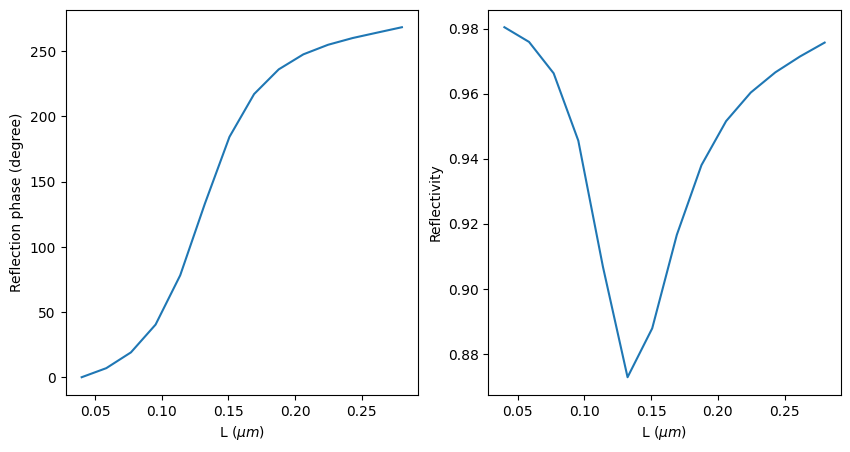

In [13]:
# plot the reflection phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = np.unwrap(np.angle(r)) * 180 / np.pi
theta = theta - theta[0]
ax1.plot(Ls, theta)
ax1.set_xlabel("L ($\mu m$)")
ax1.set_ylabel("Reflection phase (degree)")

# plot the reflectivity
ax2.plot(Ls, np.abs(r) ** 2)
ax2.set_xlabel("L ($\mu m$)")
ax2.set_ylabel("Reflectivity")
plt.show()


## Super Cell Simulation 

### Simulation Setup 

The above phase relation provides a look-up table such that a gradient metasurface with an arbitrary phase profile can be designed. For example, when designing a metalens, a parabolic phase profile can be used. In this example, we aim to construct a beam steering reflector. Therefore, a linear phase profile is used. 

Here we adapt the idea from the referenced paper and design a super cell that consists of 10 antennas of 5 different lengths. The lengths are 40 nm, 106 nm, 128 nm, 150 nm, and 260 nm. The plot below confirms that this design indeed yields a nearly linearly varying phase across the super cell.

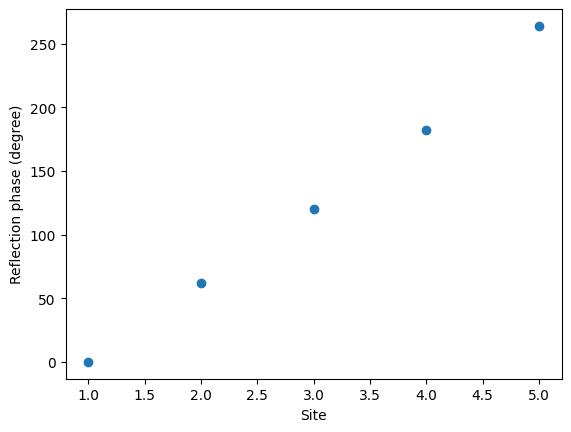

In [14]:
N_sample = 5  # number of antenna lengths in a super cell
N_repeat = 2  # number of repeated antenna lengths

Ls_design = np.array([0.04, 0.106, 0.128, 0.15, 0.26])  # designed antenna lengths

theta_design = np.interp(
    Ls_design, Ls, theta
)  # extract the reflection phase by interpolation the above simulation result

# plot phase across the super cell
plt.scatter(np.linspace(1, N_sample, N_sample), theta_design)
plt.xlabel("Site")
plt.ylabel("Reflection phase (degree)")
plt.show()


To define the geometry of the super cell, we first generate the antennas systematically.

In [15]:
# construct ten antennas given the designed antenna lengths
antennas = []
xs = np.linspace(
    Lx / 2, (N_sample * N_repeat - 0.5) * Lx, N_sample * N_repeat
)  # x coordinates of each antenna

# systematically generate antennas in the super cell
for i in range(N_sample):
    for j in range(N_repeat):
        antennas.append(
            td.Structure(
                geometry=td.Box.from_bounds(
                    rmin=(-w / 2 + xs[2 * i + j], -Ls_design[i] / 2, d2),
                    rmax=(w / 2 + xs[2 * i + j], Ls_design[i] / 2, d2 + d1),
                ),
                medium=au,
            )
        )

super_cell = antennas + [spacer, sub, gold_layer]


To visualize the reflected field, we add a [FieldMonitor](../_autosummary/tidy3d.FieldMonitor.html) in the xz plane. The simulation domain is lengthened in the z direction such that we can better visualize the reflected field.

In [16]:
# define a field monitor to visualize the reflected field
field_monitor = td.FieldMonitor(
    center=(0, 0, 0),
    size=(td.inf, 0, td.inf),
    freqs=[freq0],
    name="field",
)


# define the super cell simulation
sim = td.Simulation(
    size=(Lx * N_sample * N_repeat, Ly, 3 * Lz),
    center=(Lx * N_sample * N_repeat / 2, 0, 0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lda0),
    structures=super_cell,
    sources=[plane_wave],
    monitors=[monitor_r, field_monitor],
    run_time=run_time,
    boundary_spec=boundary_spec,
)


[15:26:57] WARNING: Default value for the field monitor           ]8;id=471247;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py\monitor.py]8;;\:]8;id=226762;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/components/monitor.py#261\261]8;;\
           'colocate' setting has changed to 'True' in Tidy3D                   
           2.4.0. All field components will be colocated to the                 
           grid boundaries. Set to 'False' to get the raw fields                
           on the Yee grid instead.                                             

Visualize the generated antenna structures.

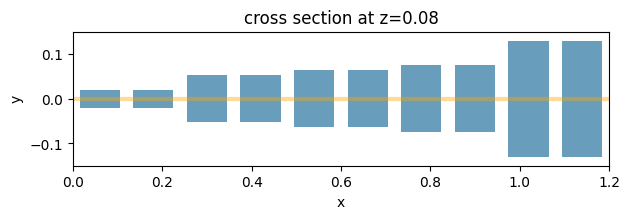

In [17]:
# visualize the antennas in the super cell
sim.plot(z=d2 + d1)
plt.show()


Visualize the simulation setup from the xz plane.

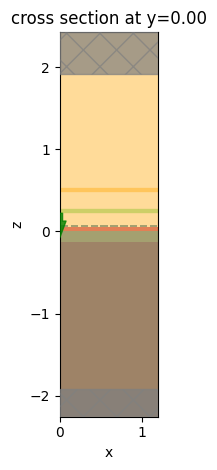

In [18]:
# visualize the xz plane
sim.plot(y=0)
plt.show()


To have a better visualization, we can also plot the simulation in 3D.

In [19]:
sim.plot_3d()

Submit the simulation to the server.

In [20]:
job = web.Job(simulation=sim, task_name="beam_steering_metasurface", verbose=True)
sim_data = job.run(path="data/simulation_data.hdf5")


           Created task 'beam_steering_metasurface' with task_id   ]8;id=720536;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=928604;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#188\188]8;;\
           'fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1'.                       

           View task using web UI at                               ]8;id=22916;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=137200;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#190\190]8;;\
           ]8;id=254024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=333453;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\taskId]8;;\]8;id=254024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\=]8;;\]8;id=588368;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\fdve]8;;\]8;id=254024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\-]8;;\              
           ]8;id=254024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f493f3f2-5a6e-4204-8ce4-b70611e4702av1\f493f3f2-5a6e-4204-8ce4-b70611e4702av1']8;;\.                             

Output()

[15:26:58] status = queued                                         ]8;id=522531;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=613843;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#361\361]8;;\

Output()

[15:27:02] status = preprocess                                     ]8;id=577614;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=470965;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#355\355]8;;\

[15:27:05] Maximum FlexCredit cost: 0.025. Use                     ]8;id=355336;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=48830;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#341\341]8;;\
           'web.real_cost(task_id)' to get the billed FlexCredit                
           cost after a simulation run.                                         

           starting up solver                                      ]8;id=365615;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=375091;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#377\377]8;;\

           running solver                                          ]8;id=694591;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=462565;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#386\386]8;;\

           To cancel the simulation, use 'web.abort(task_id)' or   ]8;id=477293;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=875386;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#387\387]8;;\
           'web.delete(task_id)' or abort/delete the task in the                
           web UI. Terminating the Python script will not stop the              
           job running on the cloud.                                            

Output()

[15:27:16] early shutoff detected, exiting.                        ]8;id=559586;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=373835;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#404\404]8;;\

           status = postprocess                                    ]8;id=21805;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=608185;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#420\420]8;;\

Output()

[15:27:22] status = success                                        ]8;id=450306;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=186746;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#427\427]8;;\

Output()

[15:27:23] loading SimulationData from data/simulation_data.hdf5   ]8;id=764097;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:]8;id=458378;file:///home/momchil/Drive/flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py#591\591]8;;\

### Result Analysis 

After the simulation is complete, we first extract the reflected angles and power from the [DiffractionMonitor](../_autosummary/tidy3d.DiffractionMonitor.html). Then, plot the power and angle of each diffraction order as a scatter plot in polar coordinate. 

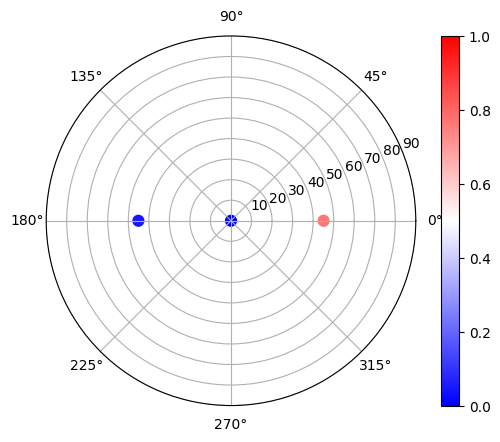

In [21]:
theta = np.array(sim_data["R"].angles[0])  # diffraction angle theta
phi = np.array(sim_data["R"].angles[1])  # diffraction angle phi
power = np.array(sim_data["R"].power)  # diffraction power of each order

# plot the power and angle in polar coordinate
fig, ax = plt.subplots(subplot_kw={"projection": "polar"})
plt.scatter(phi, theta * 180 / np.pi, s=60, c=power, vmin=0, vmax=1, cmap="bwr")
ax.set_rlim(0, 90)
plt.colorbar()
plt.show()


To see the power values more clearly, we plot the relationship between the power and the diffraction order. 

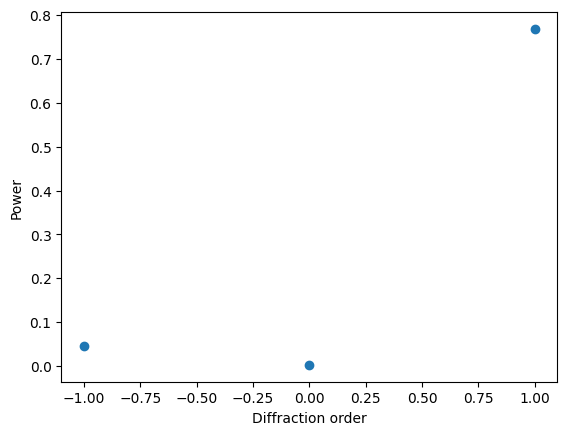

In [22]:
plt.scatter(sim_data["R"].orders_x, sim_data["R"].power.values[:, 0])
plt.xlabel("Diffraction order")
plt.ylabel("Power")
plt.show()


The Above result shows that about 80% of the power is diffracted to about 45 degree. This is consistent with our design since we have $2\pi/L_x\approx 0.71k_0 $, where $L_x$ = 1200 nm is the super cell size in the x direction. This gives a diffraction angle of $sin^{-1}(0.71)\approx 45^{\circ}$ at the first diffraction order. Note that another 5% of the power that is also diffracted to 45 degree corresponds to the -1 diffraction order.

Lastly, visualize the field distribution at the xz plane. The field above the super cell resembles a plane wave propagating at about 45$^{\circ}$. Clearly it is not a perfect plane wave. The distortion is due to the fact that 5% of the power is diffracted to the -1 order and about 1% to the 0 order. This design can potentially be further optimized.

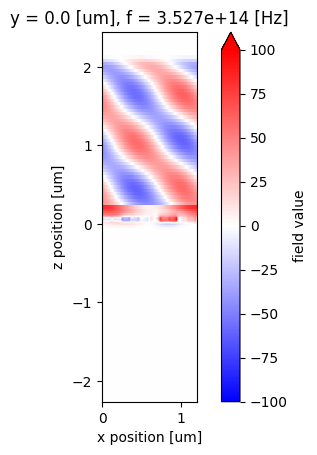

In [23]:
# plot Ey distribution
fig, ax = plt.subplots()
Ey = sim_data["field"].Ey.sel(f=freq0).real
Ey.plot(x="x", y="z", ax=ax, vmin=-100, vmax=100, cmap="bwr")
ax.set_aspect("equal")
